<a href="https://colab.research.google.com/github/mnansary/pyF2O/blob/master/colab_gen_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# colab specific task
*   mount google drive
*   TPU check
*   Check TF version
*   Change to git repo 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

# tpu check
import os
import pprint
import tensorflow as tf
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', TPU_ADDRESS)

  with tf.Session(TPU_ADDRESS) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

tf.__version__

TPU address is grpc://10.49.94.162:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 16207682184244365685),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2961855202938400171),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1254055479044319684),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4819075932927995371),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 15071073411589098388),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3634996257852310545),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 4291234264391328660),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 12898002072940587110),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 2052839844020

'1.15.0'

In [0]:
cd /content/gdrive/My\ Drive/PROJECTS/HACT/pyACTRECOG/

/content/gdrive/My Drive/PROJECTS/HACT/pyACTRECOG


# GCS specific task 
* **auth user**
* **save** and **upload** credentials to **tpu**
* set project information

In [0]:
# auth user for cloud SDK
from google.colab import auth
auth.authenticate_user()

In [0]:
# Save credentials
import json
SERVICE_KEY_PATH='/content/adc.json' # @param
# Upload credentials to TPU.
with tf.Session(TPU_ADDRESS) as sess:    
    with open(SERVICE_KEY_PATH, 'r') as f:
        auth_info = json.load(f)
        tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)
# set service_account
JSON_DATA=json.load(open(SERVICE_KEY_PATH))
SERVICE_ACCOUNT=str(JSON_DATA['client_id']).split('.')[0]
print('Service Account:',SERVICE_ACCOUNT)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Service Account: 32555940559


#### SET PROJECT INFORMATION 

In [0]:
PROJECT_ID    ='record-1106154'     # @param 
BUCKET        ='tfalldata'          # @param 
TFIDEN        ='TFRECORD'            # @param
# LIST FILES
TFRECORDS_DIR= 'gs://{}/{}/'.format(BUCKET,TFIDEN)
!gcloud config set project {PROJECT_ID}
!gsutil ls {TFRECORDS_DIR}


Updated property [core/project].
gs://tfalldata/TFRECORD/Eval/
gs://tfalldata/TFRECORD/Train/


# ConvNet3D Model Training

#### Data 
* Set **FLAGS** and **PARAMS**
* Create **Train** and **Eval** Data Generator


In [0]:
import sys
sys.path.append('.')
import numpy as np 

class FLAGS:
    BATCH_SIZE      = 32  #@param
    IMAGE_DIM       = 64   #@param
    NB_CHANNELS     = 3    #@param
    MIN_SEQ_LEN     = 6    #@param
    NB_CLASSES      = 17   #@param
    SHUFFLE_BUFFER  = 6400 #@param

MODEL_DIR           = '/content/gdrive/My Drive/PROJECTS/HACT/Model/' # @param
MODEL_NAME          = 'convNet3D' # @param
EPOCHS              =  5           # @param
NB_TRAIN_DATA       =  326144       # @param
NB_EVAL_DATA        =  5120        # @param
NB_TOTAL_DATA       =  NB_TRAIN_DATA + NB_EVAL_DATA 
STEPS_PER_EPOCH     =  NB_TOTAL_DATA // FLAGS.BATCH_SIZE 
VALIDATION_STEPS    =  NB_EVAL_DATA  // FLAGS.BATCH_SIZE 
CHECK_DATA          =  False
LEARNING_RATE       = 1e-5 #@param

LOAD_WEIGHTS=True #@param
EPOCHS_DONE_BEFORE_RECONNECT=0  #@param
EPOCHS=EPOCHS-EPOCHS_DONE_BEFORE_RECONNECT

#### Data Generator

In [0]:
from google.cloud import storage
from functools import partial

client = storage.Client(PROJECT_ID)
# get bucket from the project
bucket=client.get_bucket(BUCKET)
print(bucket)

def data_input_fn(FLAGS,mode): 
    
    def _parser(example):
      data  ={ 'feats':tf.io.FixedLenFeature((FLAGS.MIN_SEQ_LEN,FLAGS.IMAGE_DIM,FLAGS.IMAGE_DIM,FLAGS.NB_CHANNELS),tf.float32),
                'label':tf.io.FixedLenFeature((),tf.int64)
      }    
      
      parsed_example=tf.io.parse_single_example(example,data)
      
      feats=tf.cast(parsed_example['feats'],tf.float32)
      feats=tf.reshape(feats,(FLAGS.MIN_SEQ_LEN,FLAGS.IMAGE_DIM,FLAGS.IMAGE_DIM,FLAGS.NB_CHANNELS))
      
      idx = tf.cast(parsed_example['label'], tf.int64)
      label=tf.one_hot(idx,FLAGS.NB_CLASSES,dtype=tf.int64)
      
      return feats,label

    dataset = tf.data.TFRecordDataset([os.path.join('gs://{}/'.format(BUCKET), f.name) for f in bucket.list_blobs(prefix='{}/{}'.format(TFIDEN,mode))])
    #dataset = dataset.cache()
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(FLAGS.SHUFFLE_BUFFER,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(FLAGS.BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(-1) # autotune    
    return dataset

def train_in_fn():
    return data_input_fn(FLAGS,'Train')    

def eval_in_fn():    
    return data_input_fn(FLAGS,'Eval')


<Bucket: tfalldata>


#### MODEL

In [0]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv3D,MaxPooling3D,Activation,ZeroPadding3D,TimeDistributed,Conv2D,MaxPooling2D
from tensorflow.keras.layers import Dropout,Dense,Flatten,GlobalAveragePooling2D,LSTM
from tensorflow.keras.layers import AveragePooling2D,Input,Concatenate,BatchNormalization,Input
from tensorflow.keras.regularizers import l2

def convNet3D(seq_len=6,img_dim=64,nb_channels=3,nb_classes=17,drop_out=0.2,weight_decay=1e-4):
    in_shape=(seq_len,img_dim,img_dim,nb_channels)
    feature_spec=[128,256,512,512]
    IN=Input(shape=in_shape)
    # 1st layer group	    
    X=Conv3D(64,(3, 3, 3), activation='relu',padding='same', name='INITIAL_CONV3D',kernel_regularizer=l2(weight_decay))(IN)
    X=MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='INITIAL_POOL3D')(X)
    X=Activation('relu')(X)
    X=BatchNormalization()(X)	    
    # conv layer gropus	    
    for n,nb_filter in enumerate(feature_spec):	   
        X=Conv3D(nb_filter, (3, 3, 3), activation='relu',padding='same',kernel_regularizer=l2(weight_decay), name='CONV3D_{}_C1'.format(n+1))(X)
        X=Conv3D(nb_filter, (3, 3, 3), activation='relu',padding='same',kernel_regularizer=l2(weight_decay), name='CONV3D_{}_c2'.format(n+1))(X)
        X=MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='POOL3D_{}'.format(n+1))(X)
        X=Activation('relu')(X)
        X=BatchNormalization()(X)	           
    # FC layers group	   
    X=Flatten(name='FLATTEN')(X)	    
    X=Dense(4096, activation='relu', name='DENSE_1')(X)
    if drop_out:
            X=Dropout(drop_out,name='DROP_OUT_D-1')(X)	    
    X=Dense(4096, activation='relu', name='DENSE_2')(X)
    if drop_out:
            X=Dropout(drop_out,name='DROP_OUT_D-2')(X)	    
    X=Dense(nb_classes, activation='softmax',name='DENSE_CLASS')(X)
    return Model(inputs=IN,outputs=X)


#### COMPILE MODEL




In [0]:
import sys
sys.path.append('.')
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

tf.logging.set_verbosity(tf.logging.INFO)
resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)
with strategy.scope():
  model=convNet3D(seq_len=FLAGS.MIN_SEQ_LEN,
                  img_dim=FLAGS.IMAGE_DIM,
                  nb_channels=FLAGS.NB_CHANNELS,
                  nb_classes=FLAGS.NB_CLASSES)
  model.summary()
  model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),   
                loss=categorical_crossentropy,
                metrics=['accuracy'])
  if LOAD_WEIGHTS:
    model.load_weights=os.path.join(MODEL_DIR,'{}.h5'.format(MODEL_NAME))


INFO:tensorflow:Initializing the TPU system: 10.49.94.162:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.49.94.162:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 16207682184244365685)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1254055479044319684)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4819075932927995371)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 15071073411589098388)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/devi

#### Train


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_DIR,'{}.h5'.format(MODEL_NAME)), verbose=1, save_best_only=True)
history=model.fit(train_in_fn(),
                    epochs= EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_data=eval_in_fn(),
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/5
160/160 [==============================] - 11s 70ms/step

Epoch 00001: val_loss improved from inf to 0.71126, saving model to /content/gdrive/My Drive/PROJECTS/HACT/Model/convNet3D.h5
10352/10352 [==============================] - 674s 65ms/step - loss: 1.5660 - acc: 0.5870 - val_loss: 0.7113 - val_acc: 0.8502
Epoch 2/5
160/160 [==============================] - 12s 75ms/step

Epoch 00002: val_loss improved from 0.71126 to 0.45541, saving model to /content/gdrive/My Drive/PROJECTS/HACT/Model/convNet3D.h5
10352/10352 [==============================] - 662s 64ms/step - loss: 0.5821 - acc: 0.8926 - val_loss: 0.4554 - val_acc: 0.9377
Epoch 3/5
160/160 [==============================] - 14s 86ms/step

Epoch 00003: val_loss improved from 0.45541 to 0.39751, saving model to /content/gdrive/My Drive/PROJECTS/HACT/Model/convNet3D.h5
10352/10352 [==============================] - 668s 65ms/step - loss: 0.4236 - acc: 0.9446 - val_loss: 0.3975 - val_acc: 0.9533
Epoch 4/5
160/160 [=======

#### Save Model



In [0]:
model.save_weights(os.path.join(MODEL_DIR,'{}_final.h5'.format(MODEL_NAME)))

#### Plot Training Histoty

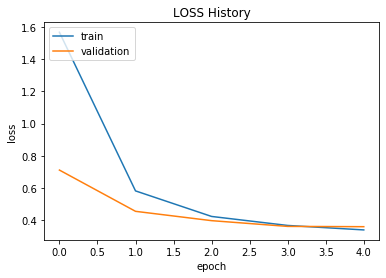

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(MODEL_DIR,'{}_history.png'.format(MODEL_NAME)))